## Gemini spectrum

In [1]:
import ipympl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from astropy.io import fits
from glob import glob
import lightkurve as lk
%matplotlib notebook
from astropy.wcs import WCS

from mpfit import mpfit

/Users/ryanr/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/ryanr/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig_width_pt = 240.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

In [3]:
def F(x, p):

	# The model to be fitted to the data

	return  p[0] * np.exp(-((x-p[1])**2)/(2*p[2]**2))



def myfunct(p, fjac=None, x=None, y=None, err=None):

	# The model evaluated at the provided x values with parameters stored in p

	model = F(x, p)

	# The deviates are the differences between the measurements y and the model 

	# evaluated at each point x normalised by the standard deviation in the 

	# measurement.

	deviates = np.array((y - model) / err, dtype=float)

	# We return p status flag and the deviates.

	return 0, deviates

model = lambda x, p : p[0] * np.exp(-((x-p[1])**2)/(2*p[2]**2))	# the model.

In [5]:
path = '/Users/ryanr/Documents/PhD/coding/Kepler/pipelines/203830112/gemini/C11_CVobj_clean.fits'
hdu = fits.open(path)
header = hdu[0].header

In [6]:
data = hdu[0].data
sig_data = 0.2 * data
sig_data[:] = 0.02
wav = np.arange(data.shape[0]) * header['CDELT1'] + header['CRVAL1']

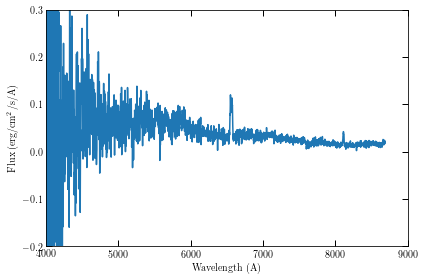

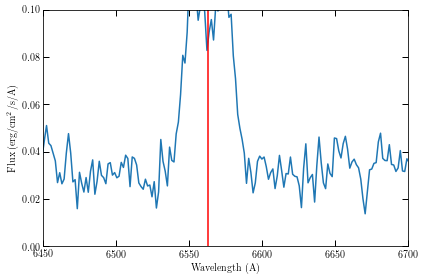

In [7]:
plt.figure()
plt.plot(wav,data)
plt.ylim(-.2,.3)
plt.xlim(4000,9000)
plt.ylabel('Flux (erg/cm$^2$/s/A)')
plt.xlabel('Wavelength (A)')
plt.tight_layout()

plt.figure()
plt.plot(wav,data)
plt.axvline(6562.8,color='red')

plt.ylim(0,0.1)
plt.xlim(6450,6700)
plt.ylabel('Flux (erg/cm$^2$/s/A)')
plt.xlabel('Wavelength (A)')
plt.tight_layout()

In [8]:
np.where(wav <=6700)[0][-1]

1818

In [9]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

/Users/ryanr/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


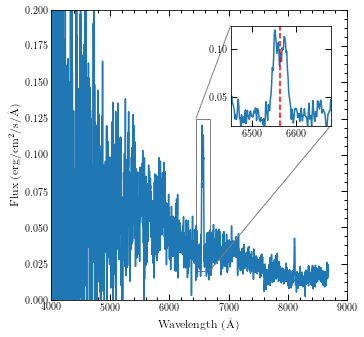

In [11]:
fig, ax = plt.subplots()
ax.plot(wav,data)
plt.minorticks_on()
plt.ylim(0,.2)
plt.xlim(4000,9000)
plt.ylabel(r'Flux (erg/cm$^2$/s/\AA)',fontsize=12)
plt.xlabel(r'Wavelength (\AA)',fontsize=12)
axins = inset_axes(ax,width='25%',height='25%',bbox_to_anchor=([-70,-70,400,400]))
axins.plot(wav[1652:1817],data[1652:1817])
axins.axvline(6562.8,color='red',ls='--')

# sub region of the original image
x1, x2, y1, y2 = 6450, 6680, 0.020, 0.125
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)


# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
#fig.set_size_inches(1.5*fig_width,1.5*fig_width)
plt.tight_layout()
fig.set_size_inches(1.5*fig_width,1.5*fig_width)
plt.savefig('Gem_spec.pdf');

In [11]:
-2.5*np.log10(0.02*(6500**2)/3e18) - 48.6

-17.224338635575076

In [18]:
-2.5*np.log10(1e-13) - 48.6

-16.1

In [33]:
index = np.where(np.isclose(wav,6560,atol=100))

In [157]:
beta = ((ls/lo)**2-1)/(1+(ls/lo)**2)
def Velocity(lo):
    ls = 6562.8
    c = 299792458
    beta = ((ls/lo)**2-1)/(1+(ls/lo)**2)
    vel = c*beta
    return vel

Calculate the orbital radius of the superhump

In [80]:
omega = 2*np.pi/(80*60) # 80 mins for a complete orbit
r = 4E5/omega

In [88]:
rkm = r/1000
rwdr = rkm/7000

In [89]:
rwdr

43.65392724806273

## Fit the double peak

In [119]:
c = 299792458
speed = wav[index]
speed = c * ((ls/speed)**2 - 1)/(1 + (ls/speed)**2)/1000

In [111]:
from astropy.modeling import models, fitting

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005635605401613303
            Iterations: 47
            Function evaluations: 379
            Gradient evaluations: 47


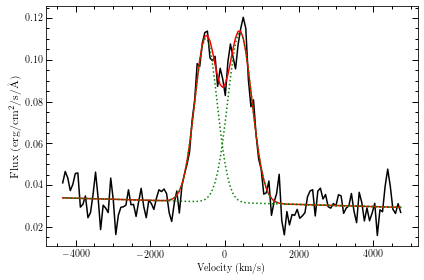

In [154]:
xdata = wav[index]
ydata = data[index]
ind = (xdata <= 6525) | (xdata >= 6600)
# Linear model
l1 = models.Polynomial1D(1)#(0.1,0.02)
l_init = l1
fitter = fitting.LinearLSQFitter()
l_fit = fitter(l_init, xdata[ind], ydata[ind])

detrend = ydata - l_fit(xdata)

g1 = models.Gaussian1D(0.1, 6550, 1.0) # First gaussian - init guess
g2 = models.Gaussian1D(0.9, 6570, 1.0) # Second gaussian - init guess

g_tot = g1 + g2 # Model is two sum of two Gaussians

# Now to fit the data create a new superposition with initial
# guesses for the parameters:
gg_init = g_tot
fitter = fitting.SLSQPLSQFitter()
gg_fit = fitter(gg_init, xdata, detrend)

# Plot the data with the best-fit model
plt.figure()
plt.plot(speed, detrend + l_fit(xdata), 'k')
plt.plot(speed, gg_fit[0](xdata) + gg_fit[1](xdata) + l_fit(xdata), 'r-')
plt.plot(speed, gg_fit[0](xdata) + l_fit(xdata), 'g:')
plt.plot(speed, gg_fit[1](xdata) + l_fit(xdata), 'g:')

plt.minorticks_on()
plt.ylabel(r'Flux (erg/cm$^2$/s/\AA)',fontsize=12)
plt.xlabel(r'Velocity (km/s)')
plt.tight_layout()
fig.set_size_inches(1.5*fig_width,1.5*fig_width)
plt.savefig('Spec_fit.pdf');


In [155]:
gg_fit[0]

<Gaussian1D(amplitude=0.08162542, mean=6553.81360076, stddev=7.05133427)>

In [156]:
gg_fit[1]

<Gaussian1D(amplitude=0.07837323, mean=6573.8264413, stddev=6.65186914)>

In [161]:
Velocity(6573.81360076)/1000

-502.6854291062593

In [13]:
wcs = WCS(header)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [22]:
wcs.all_pix2world((0),0)

IndexError: tuple index out of range

In [29]:
hdu[0].error

AttributeError: 'PrimaryHDU' object has no attribute 'error'

In [15]:
test = np.zeros((len(data),2))
test[:,0] = wav
test[:,1] = data

In [16]:
test

array([[ 3.95881934e+03, -2.35866547e+01],
       [ 3.96032735e+03, -2.35858650e+01],
       [ 3.96183537e+03, -2.35891380e+01],
       ...,
       [ 8.88702280e+03,  1.87726656e-03],
       [ 8.88853082e+03, -7.84186460e-03],
       [ 8.89003884e+03, -1.47705153e-03]])

In [17]:
np.savetxt('/Users/ryanr/Desktop/test.txt',test)

In [144]:
header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    1 / Number of axes                                 
NAXIS1  =                 3271 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
OBJECT  = 'KSN Fest'           / Name of the object observed                    
DATE    = '2018-07-25T17:26:23' / Date FITS file was generated                  
IRAF-TLM= '2018-07-25T17:26:23' / Time of last modification                     
FIXPIX  = 'Jul 25  9:38 Bad pixel file is tmpbpm11756_466.pl'                   
CTYPE1  = 'LINEAR  '           / R.A. in tangent plane projection               
CRPIX1  =                   1. / Ref pix of axis 1                              
CRVAL1  =        3958.819335